In [12]:
%%file Para_VaR.m
%Parametric VaR(Delta-Normal VaR & Delta-Gamma VaR)

function VaR = Para_VaR(S, r, HS_Vol_Y, q, CL, N, POS)
    
    %Option Portfolio Data
    LS      = POS(:, 1);         %Long/Short
    C_P     = POS(:, 2);         %Call/Put
    NC      = POS(:, 3);         %# of Contracts
    M       = POS(:, 4);         %Multiplier
    X       = POS(:, 5);         %Strike
    T       = POS(:, 6);         %Time to Maturity
    Imp_Vol = POS(:, 7);         %Implied Volatility
    MP      = POS(:, 8);         %Option Market Price
    
    %Option Portfolio Greeks
    sz    = size(POS);
    Delta = zeros(sz(1), 1);
    Gamma = zeros(sz(1), 1);
    for i=1:sz(1)
        Delta(i) = LS(i) * NC(i) * M(i) * BS(C_P(i), 2, S, X(i), r, T(i), Imp_Vol(i), q);
        Gamma(i) = LS(i) * NC(i) * M(i) * BS(C_P(i), 3, S, X(i), r, T(i), Imp_Vol(i), q);
    end
    
    Port_Delta = sum(Delta);
    Port_Gamma = sum(Gamma);
    
    %VaR
    Alpha    = norminv(CL);          %Critical Values
    HS_Vol_D = HS_Vol_Y / sqrt(250); %Historical 1-year vol
    
    %Delta-Normal VaR
    DN_VaR   = abs(Alpha * Port_Delta * S * HS_Vol_D * sqrt(N));
    
    %Delta-Gamma VaR
    DG_VaR   = (abs(Port_Delta) * (Alpha * HS_Vol_D * S) - 0.5 * Port_Gamma * (Alpha * HS_Vol_D * S)^2) * sqrt(N);
    
    VaR = [DN_VaR DG_VaR];

Created file '/Users/changsoo/Desktop/논문/Matlab/Para_VaR.m'.


In [2]:
%%file HS_VaR.m
%Historical Simulation VaR

function VaR = HS_VaR(S, r, q, CL, N, POS, HS_Price)
    %Historical Stock Price -> Log Price
    LogRet = price2ret(HS_Price);
    
    %Option Portfolio Data
    LS      = POS(:, 1);             %log/short
    C_P     = POS(:, 2);             %Call/Put
    NC      = POS(:, 3);             %# of Contracts
    M       = POS(:, 4);             %Multiplier
    X       = POS(:, 5);             %Strike
    T       = POS(:, 6);             %Time to Maturity
    Imp_Vol = POS(:, 7);             %Implied Volatility
    MP      = POS(:, 8);             %Option Market Price
    
    %1-day Stock Price Scenario
    SP = S * exp(LogRet);
    ns = length(SP);
    sz = size(POS);
    
    %Option Full Valuation
    Price = zeros(ns, sz(1));
    for i=1:ns
        for j=1:sz(1)
            Price(i, j) = BS(C_P(j), 1, SP(i), X(j), r, T(j) -1/365, Imp_Vol(j), q);
        end
    end
    
    %Option Portfolio P&L
    PL = zeros(ns, sz(1));
    for i=1:ns
        for j=1:sz(1)
            PL(i, j) = LS(j) * NC(j) * M(j) * (Price(i, j) - MP(j));
        end
    end
    Port_PL = sum(PL, 2);
    
    %Hostoricl Simulation VaR
    VaR = -prctile(sort(Port_PL, 1), 100 * (1-CL)) * sqrt(N);
    
    

Created file '/Users/changsoo/Desktop/논문/Matlab/HS_VaR.m'.


In [3]:
%%file MC_VaR.m
%Monte Carlo Simulation VaR

function VaR = MC_VaR(S, r, HS_Vol_Y, q, CL, N, ns, POS)

    %Option Portfolio Data
    LS      = POS(:, 1);             %log/short
    C_P     = POS(:, 2);             %Call/Put
    NC      = POS(:, 3);             %# of Contracts
    M       = POS(:, 4);             %Multiplier
    X       = POS(:, 5);             %Strike
    T       = POS(:, 6);             %Time to Maturity
    Imp_Vol = POS(:, 7);             %Implied Volatility
    MP      = POS(:, 8);             %Option Market Price
    
    %1-day stock price scenario
    HS_Vol_D = HS_Vol_Y / sqrt(250);
    w        = randn(ns, 1);
    S_Ret    = w * HS_Vol_D;
    SP       = S * exp(S_Ret);
    
    %Option Full Valuation
    sz = size(POS);
    Price = zeros(ns, sz(1));
    for i=1:ns
        for j=1:sz(1)
            Price(i, j) = BS(C_P(j), 1, SP(i), X(j), r, T(j) -1/365, Imp_Vol(j), q);
        end
    end
    
    %Option Portfolio P&L
    PL = zeros(ns, sz(1));
    for i=1:ns
        for j=1:sz(1)
            PL(i, j) = LS(j) * NC(j) * M(j) * (Price(i, j) - MP(j));
        end
    end
    Port_PL = sum(PL, 2);
    
    %Historicl Simulation VaR
    VaR = -prctile(sort(Port_PL, 1), 100 * (1-CL)) * sqrt(N);
    
    %Option Portfolio P&L Distribution
    histfit(Port_PL);
    

Created file '/Users/changsoo/Desktop/논문/Matlab/MC_VaR.m'.


In [4]:
S=100; r=0.05; HS_Vol_Y=0.3; q=0.01; CL=0.95; N=1; ns=100000;
POS = [-1 1 1 1 110 0.5 0.3 5.3845;
       -1 2 1 1  90 0.5 0.3 3.3832];

In [9]:
HS_Price = csvread('Historical_Price.csv');

In [13]:
VaR = Para_VaR(S, r, HS_Vol_Y, q, CL, N, POS)


VaR =

    0.4931    0.6530



In [14]:
VaR = HS_VaR(S, r, q, CL, N, POS, HS_Price)


VaR =

    0.6345




VaR =

    0.6167



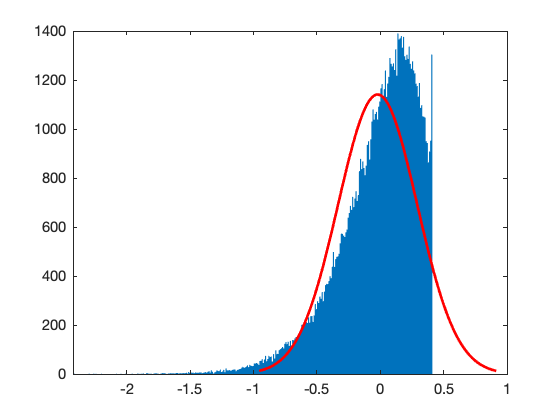

In [15]:
VaR = MC_VaR(S, r, HS_Vol_Y, q, CL, N, ns, POS)